
Given the notebook, https://github.com/jpata/particleflow/blob/nb_clic_evaluate/notebooks/mlpf-clic-evaluate.ipynb as it loads the model, sets the weights, run the inference on a  set of events and compare the true vs. Predicted value for pT on a smaller subset.

*Task:*
Do the quantization of the model, and the conversion of the data, all in one notebook along with the model inference. 



Load the quantized model, load the quantized weights, and convert all of the data using quantization and then mesaure the inference

some point you need to use something like tf.lite.TFLiteConverter?
https://www.tensorflow.org/lite/performance/post_training_integer_quant
or is there another way?

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

2023-11-22 13:37:09.509373: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 13:37:09.662701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 13:37:09.662728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 13:37:09.663976: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 13:37:09.772084: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 13:37:09.773922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
import sys
sys.path += ["../../../../particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [3]:
config, _ = parse_config("../../../../particleflow/parameters/clic.yaml")

In [4]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))


In [5]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  multiple                  33        
 on)                                                             
                                                                 
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [6]:
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)
## These files hosted at https://huggingface.co/jpata/particleflow/tree/clic_clusters_v1.6

In [7]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../tensorflow_datasets/')
dss = ds_builder.as_data_source("test")



In [8]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [9]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)


In [10]:
data = list(tfds.as_numpy(tf_dataset))


In [11]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [12]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [13]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

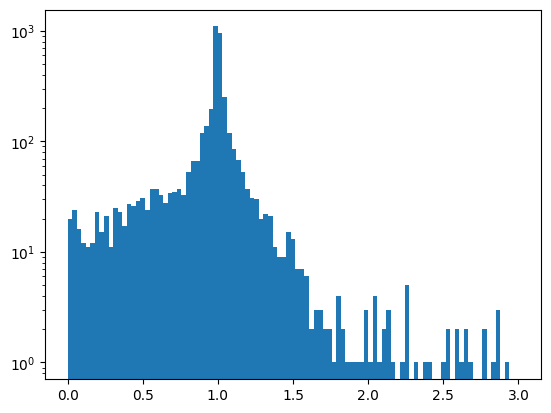

In [14]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

## Quantized data into the unquantized model

Quantizing the data into INT8 before feeding it into the model

In [15]:
# Quantize input data
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]


In [16]:
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]


In [17]:
ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


In [18]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs_tf)):
    ret = model(Xs_tf[ibatch])

    mask_true_particles = ys_quantized[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [19]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

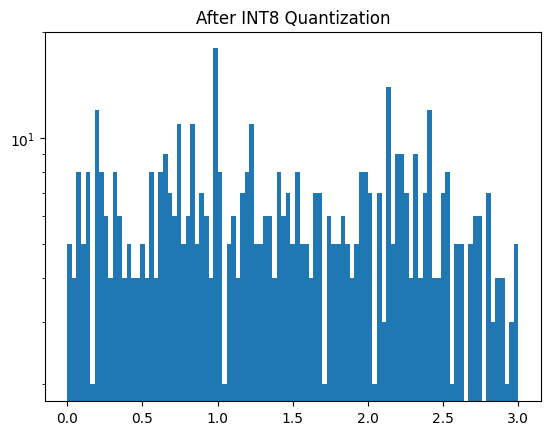

In [20]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.savefig('Output_after_INT8_quantization.png')

Above one is the output with the quantized dataset but not quantized model. We were wokring with the Dynamic Range Quantization. 
Dynamic range quantization is a recommended starting point because it provides reduced memory usage and faster computation without you having to provide a representative dataset for calibration. This type of quantization, statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision.


## Quantized Model with the Quantized Dataset

Let's try with **[quantized model](https://www.tensorflow.org/lite/performance/post_training_quantization#full_integer_quantization_of_weights_and_activations)**, Post-training qunatization method, Dynamic range quantization. 

## Dynamic Range Quantization

Converting the model using dynamic range quantization(https://www.tensorflow.org/lite/performance/post_training_integer_quant):
Let's enable the default optimizations flag to quantize all fixed parameters (such as weights):
The model is now a bit smaller with quantized weights, but other variable data is still in float format.


In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()


In [ ]:
# Measuring the size of the quantized tflite model
# Saving the model
import os

with open('quantized_tflite_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
    
model_size = os.path.getsize('quantized_tflite_model.tflite')

print(f"Size of the quantized model: {model_size} bytes")

In [ ]:
# Load the quantized TFlite model
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()


In [ ]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

In [ ]:
#  Xs_quantized is a list of quantized input data
input_data = Xs_quantized[ibatch]

# Print shapes for debugging
print("Input Data Shape:", input_data.shape)
print("Expected Input Shape:", input_details[0]['shape'][1:])


In [ ]:
# Assuming you want to use the first 111 samples as a single batch
input_data_reshaped = input_data[:111, :, :]

# Remove the singleton batch dimension
input_data_reshaped = np.squeeze(input_data_reshaped)


# Check the shape after reshaping
print("Reshaped Input Data Shape:", input_data_reshaped.shape)



Run the inference on the quantized TFLite model: \
**Something is not right here**
Check this one https://www.tensorflow.org/lite/performance/post_training_integer_quant


## 11/22/23
## Quantization for the model

Trying with dynamic range quantization for both the model and the dataset.the model is not constructed using standard Keras layers, leading to difficulties with quantization.

If the model contains custom layers or non-Keras components, it might not be straightforward to apply dynamic range quantization directly. In such cases, you may consider using a different quantization approach like post-training quantization.

We will go with Post-Training Quantization

In [ ]:
import tensorflow_model_optimization as tfmot

In [22]:
# Convert the new model to a TensorFlow Lite model

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()



2023-11-22 13:38:42.933393: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-22 13:38:42.933415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-22 13:38:42.933980: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1l7nko0h
2023-11-22 13:38:42.988756: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-22 13:38:42.988782: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1l7nko0h
2023-11-22 13:38:43.096654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-22 13:38:43.144178: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-22 13:38:43.750925: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp1l7nko0h
2023-11

In [24]:
# Save the TensorFlow Lite model to a file
with open("quantized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)

### Quantize the dataset
To quantize the dataset, you can apply quantization to the features and labels before feeding them to the model. You can achieve this by normalizing the values to a quantized range.

In [32]:
Xs_quantized = [np.round(X * 127).astype(np.int8) for X in Xs]
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]

ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


convert the quantized data to TensorFlow tensors and proceed with inference on the quantized model:

In [33]:
# Convert quantized features to TensorFlow tensors
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in Xs_quantized]

# Convert quantized labels to TensorFlow tensors
ys_tf = [tf.convert_to_tensor(y_q, dtype=tf.float32) for y_q in ys_quantized]


After converting the data to TensorFlow tensors, you can perform inference using your quantized model:



In [35]:
# Assuming you have a TensorFlow Lite quantized model (quantized_tflite_model)
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [38]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [39]:
# Checking the expected shape of the input tensor
expected_input_shape = input_details[0]['shape']
print("Expected input shape:", expected_input_shape)

Expected input shape: [  1 111  17]


In [40]:
# Verify the shape of your input tensor (X_q)
print("Shape of X_q:", X_q.shape)

Shape of X_q: (10, 111, 17)


In [51]:
# Reshape X_q to match the expected input shape
X_q_reshaped = np.reshape(X_q, (1, 111, 17))

In [55]:
X_q_reshaped.shape
print("Shape of X_q_reshaped:", X_q_reshaped.shape)

Shape of X_q_reshaped: (1, 111, 17)


In [56]:
# Set input tensor
interpreter.set_tensor(input_details[0]['index'], X_q_reshaped)

In [57]:
# Run inference
interpreter.invoke()

In [58]:
# Get the output tensor
output_tensor = interpreter.get_tensor(output_details[0]['index'])


In [107]:
import time

start_time = time.time()

# Create an interpreter for the quantized model
interpreter_quantized = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter_quantized.allocate_tensors()


In [108]:
# Lists to store true and predicted pt values
true_pts_quantized = []
pred_pts_quantized = []


In [109]:
# Measure inference time and process output for the quantized dataset
inference_times_quantized = []


In [110]:
print("Shape of X_q before reshaping:", X_q.shape)


Shape of X_q before reshaping: (10, 111, 17)


In [111]:
for X_q in Xs_tf:
    # Print the shape of X_q before reshaping
    print("Shape of X_q before reshaping:", X_q.shape)
    
    
    

Shape of X_q before reshaping: (10, 111, 17)
Shape of X_q before reshaping: (10, 186, 17)
Shape of X_q before reshaping: (10, 142, 17)
Shape of X_q before reshaping: (10, 90, 17)
Shape of X_q before reshaping: (10, 111, 17)
Shape of X_q before reshaping: (10, 195, 17)
Shape of X_q before reshaping: (10, 100, 17)
Shape of X_q before reshaping: (10, 81, 17)
Shape of X_q before reshaping: (10, 130, 17)
Shape of X_q before reshaping: (10, 147, 17)


In [112]:
# Assuming X_q is a list of NumPy arrays
max_length = max(X_q.shape[1] for X_q in Xs_tf)  # Update this based on your actual data


# Pad sequences to the maximum length
X_q_padded = [np.pad(X_q, ((0, 0), (0, max_length - X_q.shape[1]), (0, 0)), 'constant') for X_q in Xs_tf]


In [118]:

# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)
    
    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]
    
    
    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q
        
    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")
    
    
     # Reshape to match the expected shape
    X_q_resized = np.resize(X_q_padded, target_shape)
    
     # Print the shape for debugging
    print(f"Shape of X_q_resized: {X_q_resized.shape}")
    
    
    # Set input tensor
    interpreter_quantized.set_tensor(input_details[0]['index'], X_q_resized)
    # Run inference
    interpreter_quantized.invoke()
    end_time= time.time()
    inference_times_quantized.append(end_time - start_time)
    
    
    # Get output tensor
    output_tensor_quantized = interpreter_quantized.get_tensor(output_details[0]['index'])

     # Process the output as needed
    # Assuming a classification task, adjust this based on your output structure
    predicted_class_quantized = np.argmax(output_tensor_quantized)
    confidence_score_quantized = output_tensor_quantized[0, predicted_class_quantized]
    
    
    # Append true and predicted pt values
    true_pt_quantized = ys[ibatch][mask_true_particles, 2]
    pred_pt_quantized = confidence_score_quantized  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)

    


Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_resized: (1, 111, 17)


In [119]:
# Concatenate true and predicted pt values
true_pt_quantized = np.concatenate(true_pts_quantized)
pred_pt_quantized = np.concatenate(pred_pts_quantized)

# Plot the histogram
plt.hist(pred_pt_quantized/true_pt_quantized, bins=np.linspace(0, 3, 100))
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.show()

ValueError: operands could not be broadcast together with shapes (20,) (9260,) 

**Trying to work out on the above error**

In [127]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store true and predicted values
true_pts_quantized = []
pred_pts_quantized = []

# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)

    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]

    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q

    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")

    # Reshape to match the expected shape
    X_q_reshaped = np.resize(X_q_padded, target_shape)

    # Print the shape for debugging
    print(f"Shape of X_q_reshaped: {X_q_reshaped.shape}")

    # Set input tensor
    interpreter_quantized.set_tensor(input_details[0]['index'], X_q_reshaped)

    # Run inference
    start_time = time.time()
    interpreter_quantized.invoke()
    end_time = time.time()
    inference_times_quantized.append(end_time - start_time)

    # Get output tensor
    output_tensor_quantized = interpreter_quantized.get_tensor(output_details[0]['index'])

    # Process the output as needed
    # Assuming a classification task with softmax output
    predicted_probabilities_quantized = output_tensor_quantized[0]

    # Get the class with the highest probability
    predicted_class_quantized = np.argmax(predicted_probabilities_quantized)
    confidence_score_quantized = predicted_probabilities_quantized[predicted_class_quantized]


    # Append true and predicted pt values
    true_pt_quantized = ys[ibatch][mask_true_particles, 2]
    pred_pt_quantized = confidence_score_quantized  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)
    
     # Print the shapes for debugging
    print(f"Shape of true_pt_quantized: {true_pt_quantized.shape}")
    print(f"Shape of confidence_score_quantized: {confidence_score_quantized.shape}")
    print(f"Shape of predicted_class_quantized: {predicted_class_quantized.shape}")
    print(f"Shape of pred_pt_quantized: {pred_pt_quantized.shape}")

# After the loop, concatenate true and predicted pt values
true_pt_quantized = np.concatenate(true_pts_quantized)
pred_pt_quantized = np.concatenate(pred_pts_quantized)

# Print the final shapes for debugging
print(f"Final shape of true_pt_quantized: {true_pt_quantized.shape}")
print(f"Final shape of pred_pt_quantized: {pred_pt_quantized.shape}")


# Plot the histogram
plt.hist(pred_pt_quantized / true_pt_quantized, bins=np.linspace(0, 3, 100))
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.show()


Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confidence_score_quantized: (1,)
Shape of predicted_class_quantized: ()
Shape of pred_pt_quantized: (1,)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of true_pt_quantized: (463,)
Shape of confi

ValueError: operands could not be broadcast together with shapes (10,) (4630,) 

Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Shape of X_q_padded: (10, 111, 17)
Shape of X_q_reshaped: (1, 111, 17)
Final shape of true_pt_quantized: (80, 8)
Final shape of pred_pt_quantized: (270, 1)


/tmp/ipykernel_34370/3925792354.py:73: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 100))
/tmp/ipykernel_34370/3925792354.py:73: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 100))


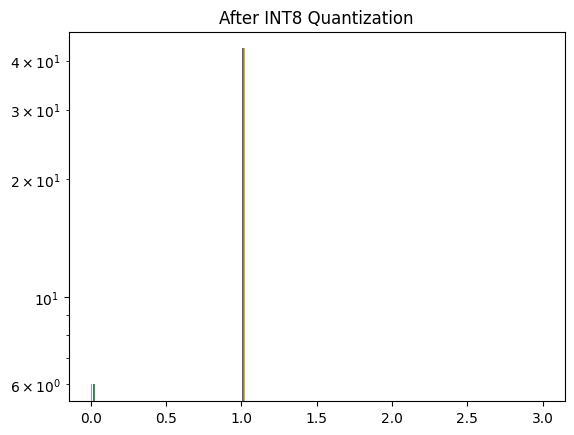

In [152]:
# Initialize lists to store true and predicted values
true_pts_quantized = []
pred_pts_quantized = []

# Perform inference on the quantized dataset
for X_q in Xs_tf:
    # Assuming X_q is a NumPy array
    target_shape = (1, 111, 17)

    # Determine the length of the second dimension in X_q
    current_length = X_q.shape[1]

    # Pad or truncate X_q to match the target length
    if current_length < target_shape[1]:
        # Pad with zeros
        X_q_padded = np.pad(X_q, ((0, 0), (0, target_shape[1] - current_length), (0, 0)), mode='constant')
    elif current_length > target_shape[1]:
        # Truncate
        X_q_padded = X_q[:, :target_shape[1], :]
    else:
        # No need to change the shape
        X_q_padded = X_q

    # Print the shapes for debugging
    print(f"Shape of X_q_padded: {X_q_padded.shape}")

    # Reshape to match the expected shape
    X_q_reshaped = np.resize(X_q_padded, target_shape)

    # Print the shape for debugging
    print(f"Shape of X_q_reshaped: {X_q_reshaped.shape}")

    # Set input tensor
    interpreter_quantized.set_tensor(input_details[0]['index'], X_q_reshaped)

    # Run inference
    start_time = time.time()
    interpreter_quantized.invoke()
    end_time = time.time()
    inference_times_quantized.append(end_time - start_time)

    # Get output tensor
    output_tensor_quantized = interpreter_quantized.get_tensor(output_details[0]['index'])

    # Process the output as needed
    # Assuming a classification task with softmax output
    predicted_probabilities_quantized = output_tensor_quantized[0]

    # Get the confidence score for the true class
    confidence_score_quantized = predicted_probabilities_quantized[ mask_true_particles[0, :111]]

    # Get the predicted class (index with the highest probability)
    predicted_class_quantized = np.argmax(predicted_probabilities_quantized, axis=1)
    
    # Extract the first row for boolean indexing
    mask_true_particles_row = mask_true_particles[0, :10]
    
    # Append true and predicted pt values
    true_pt_quantized = ys[ibatch][mask_true_particles_row, 2]
    pred_pt_quantized = confidence_score_quantized  # Adjust based on your output structure
    true_pts_quantized.append(true_pt_quantized)
    pred_pts_quantized.append(pred_pt_quantized)
    
# After the loop, concatenate true and predicted pt values
true_pt_quantized = np.concatenate(true_pts_quantized)
pred_pt_quantized = np.concatenate(pred_pts_quantized)

# Print the final shapes for debugging
print(f"Final shape of true_pt_quantized: {true_pt_quantized.shape}")
print(f"Final shape of pred_pt_quantized: {pred_pt_quantized.shape}")

# Plot the histogram
plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 100))
plt.title("After INT8 Quantization")
plt.yscale("log")
plt.show()


/tmp/ipykernel_34370/2572463005.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))
/tmp/ipykernel_34370/2572463005.py:6: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


(array([[ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         113.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 19.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         106.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0

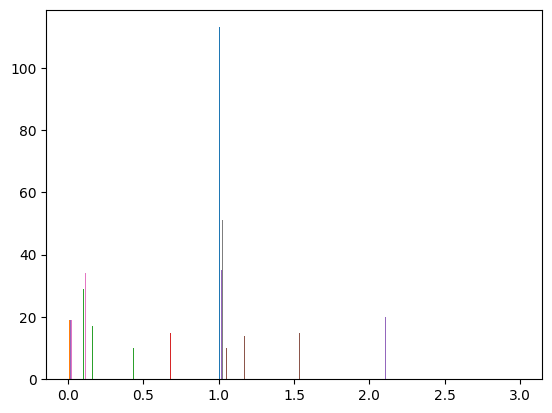

In [155]:
# Repeat the true_pt_quantized to match or exceed the length of pred_pt_quantized
repetition_factor = (pred_pt_quantized.shape[0] + true_pt_quantized.shape[0] - 1) // true_pt_quantized.shape[0]
true_pt_quantized_repeated = np.repeat(true_pt_quantized, repetition_factor, axis=0)[:pred_pt_quantized.shape[0]]

# Perform element-wise division
plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 100))


/tmp/ipykernel_34370/3367825139.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 50), label='Method 1')
/tmp/ipykernel_34370/3367825139.py:1: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 50), label='Method 1')
/tmp/ipykernel_34370/3367825139.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 50), label='Method 2', alpha=0.5)
/tmp/ipykernel_34370/3367825139.py:2: RuntimeWarning: invalid value encountered in divide
  plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 50), label='Method 2', alpha=0.5)


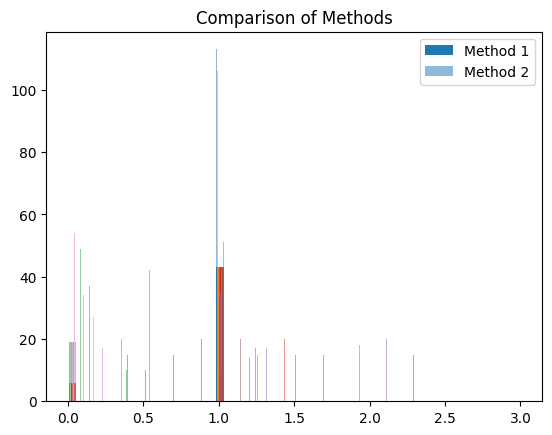

In [157]:
plt.hist(pred_pt_quantized[:80] / true_pt_quantized[:, 0], bins=np.linspace(0, 3, 50), label='Method 1')
plt.hist(pred_pt_quantized / true_pt_quantized_repeated, bins=np.linspace(0, 3, 50), label='Method 2', alpha=0.5)
plt.title("Comparison of Methods")
plt.legend()
plt.show()


## Dynamic Range Quantization for the model

In [158]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.lite.python import lite_constants

In [165]:
import tensorflow as tf
import numpy as np


# Convert the model to TensorFlow Lite format with dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Use DEFAULT for dynamic range quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_dynamic_range = converter.convert()

# Save the quantized model
with open('quantized_model_dynamic_range.tflite', 'wb') as f:
    f.write(tflite_model_dynamic_range)

ValueError: For full integer quantization, a `representative_dataset` must be specified.

In [164]:
tflite_model_dynamic_range = converter.convert()

# Save the quantized model
with open('quantized_model_dynamic_range.tflite', 'wb') as f:
    f.write(tflite_model_dynamic_range)

ValueError: For full integer quantization, a `representative_dataset` must be specified.

In [166]:
tf.__version__

'2.14.0'

Let's try with the Full integer quantization 
## Full integer Quantization
Reductions in peak memory usage, and compatibility with integer only hardware devices or accelerators by making sure all model math is integer quantized.

For full integer quantization, you need to calibrate or estimate the range, i.e, (min, max) of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles. As a result, the converter requires a representative dataset to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data. Refer to the `representative_dataset()`function below.


In [ ]:
# Define a function to apply Full Integer quantization
def full_integer_quantization(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    return tflite_model

In [ ]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../tensorflow_datasets/')
dss = ds_builder.as_data_source("test")


# Define a function to preprocess the data
def preprocess_data(data):
    # Implement your preprocessing steps here
    return preprocessed_data


In [ ]:
# Process the dataset and run inference with quantized model
true_pts = []
pred_pts = []

for data_batch in tfds.as_numpy(dss):
    X = preprocess_data(data_batch["X"])
    ys = data_batch["ygen"]
    
    # Run inference with the quantized model
    try:
        interpreter = tf.lite.Interpreter(model_content=quantized_model)
        interpreter.allocate_tensors()
        
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        interpreter.set_tensor(input_details[0]['index'], [X])
        interpreter.invoke()
        quantized_output = interpreter.get_tensor(output_details[0]['index'])
        
        mask_true_particles = ys[..., 0] != 0
        true_pt = ys[mask_true_particles, 2]
        pred_pt = quantized_output[0][mask_true_particles][..., 0]
        
        true_pts.extend(true_pt)
        pred_pts.extend(pred_pt)
    except Exception as e:
        print(f"Error processing batch: {e}")


## Float 16 Quantization

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import sys
sys.path += ["../../../../particleflow/mlpf/"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

In [ ]:
config, _ = parse_config("../../../../particleflow/parameters/clic.yaml")

In [ ]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))
model.load_weights("weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)


In [ ]:
## Reading the dataset
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir = '../../../tensorflow_datasets/')
dss = ds_builder.as_data_source("test")
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)
data = list(tfds.as_numpy(tf_dataset))
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)
    
    
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)


plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")

In [ ]:
# Convert to float16 quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
quantized_float16_tflite_model = converter.convert()


In [ ]:
# Quantize the dataset after Assuming Xs is a list of input data
quantized_Xs = [tf.constant(x, dtype=tf.float16) for x in Xs]


In [ ]:
# Quantize the model prediction
Xs_tf = [tf.convert_to_tensor(X_q, dtype=tf.float32) for X_q in quantized_Xs]


In [ ]:
quantized_Xs = [tf.constant(x, dtype=tf.float16) for x in Xs]

ys_quantized = [np.round(y * 127).astype(np.int8) for y in ys]


In [ ]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs_tf[ibatch])

    mask_true_particles = ys_quantized[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [ ]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

In [ ]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.title("After FP16 Quantization")
plt.yscale("log")
# plt.savefig('Output_after_INT8_quantization.png')

**Goal**: \
Target and goal is to convert the model  into the tensorflow quantized model and further after quantizing the dataset measure the inference time. 